In [43]:
import sys
from pathlib import Path
from dotenv import load_dotenv

# Ensure project root is on sys.path for utils imports
try:
  PROJECT_ROOT = Path(__file__).resolve().parents[1]
except NameError:
  PROJECT_ROOT = Path.cwd().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
  sys.path.append(str(PROJECT_ROOT))

# Load paths/credentials
load_dotenv()

from utils.config import get_default_tickers, get_stock_data_path
from utils.io import load_data, save_top_pairs
from utils.preprocess import get_close_cols
from utils.cointegration import engle_granger_test
from statsmodels.tsa.stattools import adfuller

# Get configuration
tickers = get_default_tickers()
file_path = get_stock_data_path()

print(f"Analyzing {len(tickers)} tickers: {', '.join(tickers)}")
print(f"Data source: {file_path}")

Analyzing 19 tickers: NVDA, AMD, MSFT, GOOGL, AAPL, V, MA, CRM, ADBE, INTC, QCOM, CSCO, ANET, ORCL, SAP, UBER, LYFT, META, SNAP
Data source: /Users/Kushal/Projects/StatArb/data/stock_data.parquet


In [44]:
# Load stock data
df = load_data(file_path)
print(f"Loaded data shape: {df.shape}")

# Extract close prices
df_close = get_close_cols(df)
print(f"Close prices shape: {df_close.shape}")
print(f"Date range: {df_close['Date'].min()} to {df_close['Date'].max()}")
print(f"\nAvailable tickers: {[col.replace('Close__', '') for col in df_close.columns if col != 'Date']}")

Loaded data shape: (1234, 116)
Close prices shape: (1234, 24)
Date range: 2020-10-01 00:00:00 to 2025-08-29 00:00:00

Available tickers: ['AAPL', 'ADBE', 'AMD', 'ANET', 'CRM', 'CSCO', 'DDOG', 'ESTC', 'GOOGL', 'INTC', 'LYFT', 'MA', 'MDB', 'META', 'MSFT', 'NVDA', 'ORCL', 'QCOM', 'SAP', 'SNAP', 'SNOW', 'UBER', 'V']


In [45]:
# Generate all unique pairs
pair_combinations = [(tickers[i], tickers[j]) 
                     for i in range(len(tickers)) 
                     for j in range(i+1, len(tickers))]

print(f"Testing {len(pair_combinations)} unique pairs for cointegration...")
print(f"Significance level: 0.05")

# Test each pair
cointegrated_pairs = []
significance = 0.05

for idx, (ticker1, ticker2) in enumerate(pair_combinations):
    # Run Engle-Granger test
    ols_results = engle_granger_test(
        df_close[f"Close__{ticker1}"], 
        df_close[f"Close__{ticker2}"]
    )
    
    # Test residuals for stationarity with ADF
    adf_results = adfuller(ols_results.resid)
    adf_pvalue = adf_results[1]
    adf_statistic = adf_results[0]
    
    # If p-value < significance, pair is cointegrated
    if adf_pvalue < significance:
        cointegrated_pairs.append({
            'pvalue': adf_pvalue,
            'adf_statistic': adf_statistic,
            'tickers': (ticker1, ticker2),
            'intercept': ols_results.params.iloc[0],
            'hedge_ratio': ols_results.params.iloc[1],
            'r_squared': ols_results.rsquared
        })
    
    # Progress indicator
    if (idx + 1) % 50 == 0:
        print(f"  Tested {idx + 1}/{len(pair_combinations)} pairs...")

print(f"\n✓ Found {len(cointegrated_pairs)} cointegrated pairs")

Testing 171 unique pairs for cointegration...
Significance level: 0.05
  Tested 50/171 pairs...
  Tested 100/171 pairs...
  Tested 150/171 pairs...

✓ Found 43 cointegrated pairs


In [46]:
# Sort by p-value (lower = stronger cointegration)
cointegrated_pairs.sort(key=lambda x: x['pvalue'])

top_n = 10
show_n = min(top_n, len(cointegrated_pairs))
print(f"Top {show_n} cointegrated pairs:")
print(f"{'Pair':<15} {'P-value':<12} {'ADF Stat':<10} {'Hedge Ratio':<12} {'R²':<8}")
print("=" * 70)

for i in range(show_n):
    pair = cointegrated_pairs[i]
    t1, t2 = pair['tickers']
    print(f"{t1}-{t2:<12} {pair['pvalue']:<12.6f} {pair['adf_statistic']:<10.4f} "
          f"{pair['hedge_ratio']:<12.4f} {pair['r_squared']:<8.4f}")

# Save top 10 pairs
save_top_pairs(cointegrated_pairs, top_n=top_n, filename='cointegrated_pairs.pkl')

Top 10 cointegrated pairs:
Pair            P-value      ADF Stat   Hedge Ratio  R²      
V-SAP          0.000040     -4.8703    0.4932       0.9102  
MA-SAP          0.000101     -4.6582    0.4960       0.9044  
V-MA           0.000357     -4.3545    0.9768       0.9710  
AAPL-ANET         0.000871     -4.1277    0.3228       0.8883  
GOOGL-SAP          0.002391     -3.8552    0.5265       0.6505  
LYFT-SNAP         0.002869     -3.8038    0.7830       0.8966  
GOOGL-META         0.003487     -3.7480    0.3997       0.6943  
NVDA-MA           0.003872     -3.7177    4.3536       0.8800  
NVDA-MSFT         0.005986     -3.5884    3.3235       0.9360  
MA-ORCL         0.008297     -3.4881    0.4688       0.8606  
Saved top 10 pairs to cointegrated_pairs.pkl


In [47]:
from utils.analysis import run_analysis, select_good_pairs

# Calculate detailed statistics for saved pairs
print("Calculating spread statistics, half-lives, and correlations...")
pair_results = run_analysis()

print(f"\n✓ Analyzed {len(pair_results)} pairs")

Calculating spread statistics, half-lives, and correlations...

Summary Statistics:
      Pair  Hedge Ratio  Intercept  Half Life   Spread Mean  Spread Std  Rolling Correlation  Cointegration P-value  ADF Statistic  R Squared
      V-MA     0.976802  -0.359580  25.997657  7.243620e-15    0.031972             0.855501               0.000357      -4.354507   0.971038
 NVDA-MSFT     3.323484 -15.471954  35.169612 -5.827141e-15    0.222466             0.595533               0.005986      -3.588417   0.936030
GOOGL-META     0.399651   2.561386  54.381852  8.127480e-15    0.131173             0.582688               0.003487      -3.747995   0.694255
 AAPL-ANET     0.322769   3.911571  25.166543 -1.055881e-15    0.069786             0.434753               0.000871      -4.127677   0.888267
 GOOGL-SAP     0.526489   2.241438  48.609547 -8.543499e-15    0.140239             0.425715               0.002391      -3.855185   0.650531
    MA-SAP     0.495962   3.506813  21.025855  3.313755e-15    0

In [48]:
# Apply trading criteria to filter pairs
print("Applying trading criteria...")
print("=" * 50)

good_pairs, all_results = select_good_pairs()

print(f"\n✓ Selected {len(good_pairs)} pairs for trading out of {len(all_results)} total")

# Sanity checks
print("\n" + "="*70)
print("SANITY CHECKS (Top 5 Pairs)")
print("="*70)
for i, pair in enumerate(good_pairs[:5], 1):
    print(f"\n{i}. {pair['Pair']}:")
    print(f"  ✓ Spread mean ≈ 0? {abs(pair['Spread Mean']) < 0.1} ({pair['Spread Mean']:.4f})")
    print(f"  ✓ ADF < -2.86? {pair['ADF Statistic'] < -2.86} ({pair['ADF Statistic']:.2f})")
    print(f"  ✓ R² > 0.5? {pair['R Squared'] > 0.5} ({pair['R Squared']:.3f})")
    print(f"  ✓ Half-life < 30? {pair['Half Life'] < 30} ({pair['Half Life']:.1f}d)")

Applying trading criteria...

Summary Statistics:
      Pair  Hedge Ratio  Intercept  Half Life   Spread Mean  Spread Std  Rolling Correlation  Cointegration P-value  ADF Statistic  R Squared
      V-MA     0.976802  -0.359580  25.997657  7.243620e-15    0.031972             0.855501               0.000357      -4.354507   0.971038
 NVDA-MSFT     3.323484 -15.471954  35.169612 -5.827141e-15    0.222466             0.595533               0.005986      -3.588417   0.936030
GOOGL-META     0.399651   2.561386  54.381852  8.127480e-15    0.131173             0.582688               0.003487      -3.747995   0.694255
 AAPL-ANET     0.322769   3.911571  25.166543 -1.055881e-15    0.069786             0.434753               0.000871      -4.127677   0.888267
 GOOGL-SAP     0.526489   2.241438  48.609547 -8.543499e-15    0.140239             0.425715               0.002391      -3.855185   0.650531
    MA-SAP     0.495962   3.506813  21.025855  3.313755e-15    0.058591             0.405334      

Generating p-value heatmap...

P-value Statistics:
Total pairs tested: 10
Significant pairs (p < 0.05): 20
Highly significant pairs (p < 0.01): 20
Very highly significant pairs (p < 0.001): 8

Min p-value: 0.000040
Max p-value: 0.008297
Median p-value: 0.002630


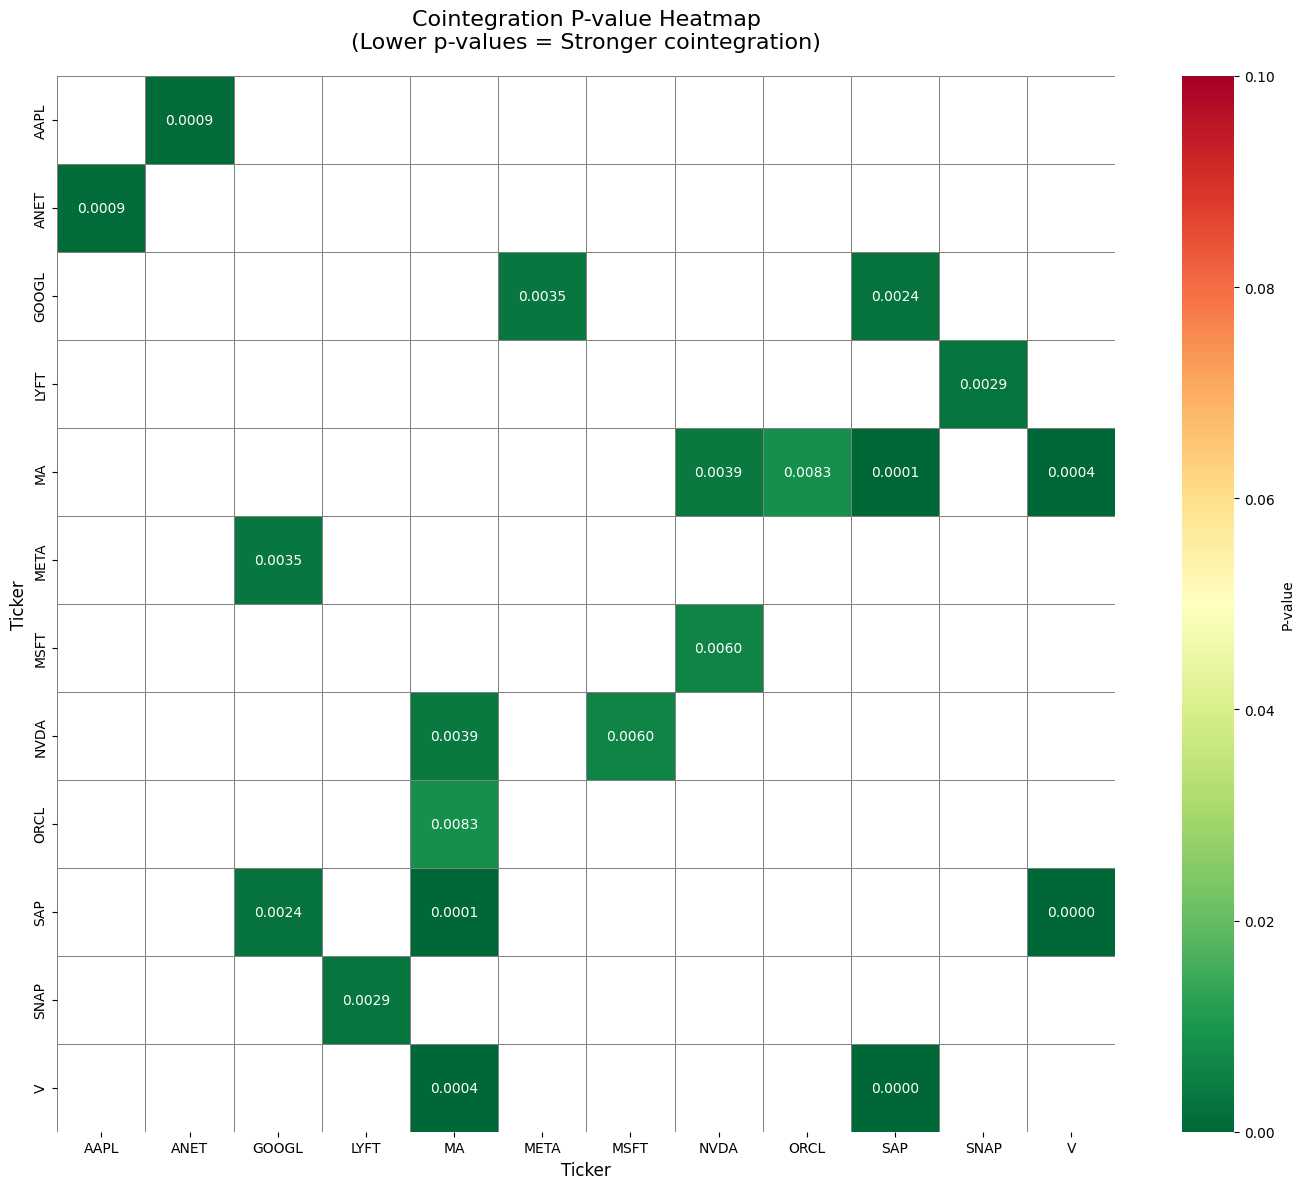


✓ Heatmap generated for 12 tickers


In [49]:
from utils.plotting import create_pvalue_heatmap
import matplotlib.pyplot as plt

print("Generating p-value heatmap...")
pvalue_matrix, tickers_in_heatmap = create_pvalue_heatmap()
plt.show()

print(f"\n✓ Heatmap generated for {len(tickers_in_heatmap)} tickers")